In [2]:
print("l")

l


In [1]:
# Now you can import the packages
import tensorflow as tf
import torch
import rasterio
import numpy as np
from keras.utils import normalize
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

In [2]:
model_path = 'D:/Jintu/Jintu_LULC/13Dec_2023/Standard Unet/unet_input13_100epoch.hdf5'

In [3]:
model = tf.keras.models.load_model(model_path)

In [4]:
import patchify
from patchify import patchify, unpatchify

In [5]:
pred_ndvi = 'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/NDVI_Landsat_1990_01_NDVI.tif.tif'
pred_ndwi = 'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/NDWI_Landsat_1990_01_NDWI.tif.tif'
pred_evi='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/EVI_Landsat_1990_01_EVI.tif.tif'
pred_nir='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Landsat_Landsat_1990_01_NIR.tif.tif'
pred_red='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Landsat_Landsat_1990_01_RED.tif.tif'
pred_swir='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Landsat_Landsat_1990_01_SWIR.tif.tif'
pred_tir='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Landsat_Landsat_1990_01_TIRS.tif.tif'
pred_cont='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/GLCM_contrast_1990.tif.tif'
pred_diss='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/GLCM_dissimilarity_1990.tif.tif'
pred_corr='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/GLCM_correlation_1990.tif.tif'
pred_slp='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Slope.tif'
pred_asp='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Aspect.tif'
pred_elv='D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Elevation.tif'

In [ ]:
import rasterio
import numpy as np
from patchify import patchify

# Paths to the prediction input images
pred_paths = [pred_nir, pred_red, pred_swir, pred_tir, pred_ndvi, pred_ndwi, pred_evi, pred_cont, pred_diss, pred_corr, pred_slp, pred_asp, pred_elv]

# Open the images using rasterio
pred_images = []
for pred_path in pred_paths:
    with rasterio.open(pred_path) as pred_dataset:
        # Read image data as numpy arrays
        pred_image = pred_dataset.read(1)
        pred_images.append(pred_image)

# Crop all input images to a size that is divisible by 256x256
patch_size = (128, 128)
SIZE_X = (min(image.shape[1] for image in pred_images) // patch_size[1]) * patch_size[1]
SIZE_Y = (min(image.shape[0] for image in pred_images) // patch_size[0]) * patch_size[0]

pred_images_cropped = [image[:SIZE_Y, :SIZE_X] for image in pred_images]

# Patchify the cropped input images
patchified_images = [patchify(image_cropped, patch_size, 128) for image_cropped in pred_images_cropped]

# Initialize an empty list to store the predicted patches
predicted_patches = []

# Loop through the patches and make predictions
for i in range(patchified_images[0].shape[0]):
    for j in range(patchified_images[0].shape[1]):
        print(i, j)

        # Extract individual patches from all input images
        input_patches = []
        for image_patches in patchified_images:
            patch = image_patches[i, j, :, :]
            patch_norm = np.expand_dims(normalize(np.array(patch), axis=1), 2)
            input_patches.append(patch_norm)

        # Expand dimensions and prepare the input for the model
        patch_input = [np.expand_dims(patch, 0) for patch in input_patches]

        # Make predictions using your model
        patch_prediction = model.predict(patch_input)

        # Extract the predicted image
        patch_predicted_img = np.argmax(patch_prediction, axis=3)[0, :, :]

        # Append the predicted patch to the list
        predicted_patches.append(patch_predicted_img)

# Now you have the list of predicted patches, you can further process and visualize them as needed.


In [ ]:
# Convert the list of predicted patches to a NumPy array
predicted_patches = np.array(predicted_patches)

In [ ]:
# Reshape the predicted patches to match the original shape
predicted_patches_reshaped = np.reshape(predicted_patches, (patchified_images[0].shape[0], patchified_images[0].shape[1], 128, 128))

In [ ]:
 reconstructed_image = unpatchify(predicted_patches_reshaped, (SIZE_Y, SIZE_X))

In [ ]:
# Show the reconstructed image
plt.imshow(reconstructed_image, cmap='viridis')  # Assuming grayscale
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

In [ ]:
from patchify import unpatchify
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Reconstruct the image from predicted patches
reconstructed_image = unpatchify(predicted_patches_reshaped, (SIZE_Y, SIZE_X))



# You can choose preferable colors for each class
class_colors = {
    1: 'green',         # Class 1: Forest
    2: 'yellow',         # Class 2: Tea Garden
    3: 'red',           # Class 3: Settlement
    4: 'gray',          # Class 4: Barren Land
    5: 'blue',          # Class 5: Water Body
    6: 'orange'         # Class 6: Home Garden
}


# Create a colormap with specific colors
cmap = mcolors.ListedColormap([class_colors[i] for i in sorted(class_colors.keys())])


# Assuming reconstructed_image has shape (1280, 2816)
reconstructed_image = np.expand_dims(reconstructed_image, axis=0)


# Show the reconstructed image
plt.imshow(reconstructed_image[0], cmap=cmap)  # Assuming grayscale
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

# Print the updated shape of the reconstructed image
print(reconstructed_image.shape)

In [18]:
path_ndwi="D:/Jintu/Jintu_LULC/13Dec_2023/NDWI/NDWI_Landsat_2004_01_NDWI.tif.tif"

In [10]:
import rasterio
import numpy as np
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def reconstruct_image_from_files(pred_paths, model, patch_size=(128, 128)):
    # Open the images using rasterio
    pred_images = []
    for pred_path in pred_paths:
        with rasterio.open(pred_path) as pred_dataset:
            # Read image data as numpy arrays
            pred_image = pred_dataset.read(1)
            pred_images.append(pred_image)

    # Crop all input images to a size that is divisible by patch_size
    SIZE_X = (min(image.shape[1] for image in pred_images) // patch_size[1]) * patch_size[1]
    SIZE_Y = (min(image.shape[0] for image in pred_images) // patch_size[0]) * patch_size[0]

    pred_images_cropped = [image[:SIZE_Y, :SIZE_X] for image in pred_images]

    # Patchify the cropped input images
    patchified_images = [patchify(image_cropped, patch_size, 128) for image_cropped in pred_images_cropped]

    # Initialize an empty list to store the predicted patches
    predicted_patches = []

    # Loop through the patches and make predictions
    for i in range(patchified_images[0].shape[0]):
        for j in range(patchified_images[0].shape[1]):
            # Extract individual patches from all input images
            input_patches = []
            for image_patches in patchified_images:
                patch = image_patches[i, j, :, :]
                patch_norm = np.expand_dims(normalize(np.array(patch), axis=1), 2)
                input_patches.append(patch_norm)

            # Expand dimensions and prepare the input for the model
            patch_input = [np.expand_dims(patch, 0) for patch in input_patches]

            # Make predictions using your model
            patch_prediction = model.predict(patch_input)

            # Extract the predicted image
            patch_predicted_img = np.argmax(patch_prediction, axis=3)[0, :, :]

            # Append the predicted patch to the list
            predicted_patches.append(patch_predicted_img)

    # Convert the list of predicted patches to a NumPy array
    predicted_patches = np.array(predicted_patches)

    # Reshape the predicted patches to match the original shape
    predicted_patches_reshaped = np.reshape(predicted_patches, (patchified_images[0].shape[0], patchified_images[0].shape[1], patch_size[0], patch_size[1]))

    # Reconstruct the image from predicted patches
    reconstructed_image = unpatchify(predicted_patches_reshaped, (SIZE_Y, SIZE_X))

    # You can choose preferable colors for each class
    class_colors = {
        1: 'darkgreen',         # Class 1: Forest
        2: 'lightgreen',        # Class 2: Tea Garden
        3: 'red',               # Class 3: Settlement
        4: 'lightgray',          # Class 4: Barren Land
        5: 'blue',                # Class 5: Water Body
        6: 'coral'                 # Class 6: Home Garden
    }

    # Create a colormap with specific colors
    cmap = mcolors.ListedColormap([class_colors[i] for i in sorted(class_colors.keys())])

    # Show the reconstructed image
    plt.imshow(reconstructed_image, cmap=cmap)
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()

    # Print the updated shape of the reconstructed image
    print(reconstructed_image.shape)

# Example usage:
# Replace 'pred_paths' with your list of file paths
# Replace 'your_model' with your trained model
# reconstruct_image_from_files(pred_paths, your_model)


In [ ]:
#with year  information

In [15]:
import rasterio
import numpy as np
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def reconstruct_image_from_files(pred_paths, model, patch_size=(64, 64), start_year=2004):
    # Open the images using rasterio
    pred_images = []
    for pred_path in pred_paths:
        with rasterio.open(pred_path) as pred_dataset:
            # Read image data as numpy arrays
            pred_image = pred_dataset.read(1)
            pred_images.append(pred_image)

    # Crop all input images to a size that is divisible by patch_size
    SIZE_X = (min(image.shape[1] for image in pred_images) // patch_size[1]) * patch_size[1]
    SIZE_Y = (min(image.shape[0] for image in pred_images) // patch_size[0]) * patch_size[0]

    pred_images_cropped = [image[:SIZE_Y, :SIZE_X] for image in pred_images]

    # Patchify the cropped input images
    patchified_images = [patchify(image_cropped, patch_size, 64) for image_cropped in pred_images_cropped]

    # Initialize an empty list to store the predicted patches
    predicted_patches = []

    # Loop through the patches and make predictions
    for i in range(patchified_images[0].shape[0]):
        for j in range(patchified_images[0].shape[1]):
            # Extract individual patches from all input images
            input_patches = []
            for image_patches in patchified_images:
                patch = image_patches[i, j, :, :]
                patch_norm = np.expand_dims(normalize(np.array(patch), axis=1), 2)
                input_patches.append(patch_norm)

            # Expand dimensions and prepare the input for the model
            patch_input = [np.expand_dims(patch, 0) for patch in input_patches]

            # Make predictions using your model
            patch_prediction = model.predict(patch_input)

            # Extract the predicted image
            patch_predicted_img = np.argmax(patch_prediction, axis=3)[0, :, :]

            # Append the predicted patch to the list
            predicted_patches.append(patch_predicted_img)

    # Convert the list of predicted patches to a NumPy array
    predicted_patches = np.array(predicted_patches)

    # Reshape the predicted patches to match the original shape
    predicted_patches_reshaped = np.reshape(predicted_patches, (patchified_images[0].shape[0], patchified_images[0].shape[1], patch_size[0], patch_size[1]))

    # Reconstruct the image from predicted patches
    reconstructed_image = unpatchify(predicted_patches_reshaped, (SIZE_Y, SIZE_X))

    # You can choose preferable colors for each class
    class_colors = {
        1: 'darkgreen',         # Class 1: Forest
        2: 'lightgreen',        # Class 2: Tea Garden
        3: 'red',               # Class 3: Settlement
        4: 'lightgray',          # Class 4: Barren Land
        5: 'blue',                # Class 5: Water Body
        6: 'coral'                 # Class 6: Home Garden
    }

    # Create a colormap with specific colors
    cmap = mcolors.ListedColormap([class_colors[i] for i in sorted(class_colors.keys())])

    # Determine the year based on the start_year and the image index
    current_year = start_year + image_index

    # Show the reconstructed image with the title
    plt.imshow(reconstructed_image, cmap=cmap)
    plt.title(f'LULC MAP_{current_year}')
    plt.axis('off')
    plt.show()

    # Print the updated shape of the reconstructed image
    print(reconstructed_image.shape)

    # Update the shape of reconstructed_image (remove the first dimension)
    #reconstructed_image = reconstructed_image[0, :, :]

    # Specify the file path to save the GeoTIFF image
    output_path = f"D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/{current_year}.tif"



    # Define the profile for the output GeoTIFF
    # You can use the profile from one of the input files as a template
    with rasterio.open(path_ndwi) as mask_ds:
        profile = mask_ds.profile
    
    # Update the profile as needed for your output
    # For example, you can update the data type, count, and nodata value
    profile.update(
        dtype=rasterio.uint8,  # Change the data type if needed
        count=1,  # Set the number of bands
        nodata=None  # Set the nodata value if needed
    )
    
    # Write the output GeoTIFF
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(reconstructed_image.astype(rasterio.uint8), 1)  # Write the op_img array to the GeoTIFF
    
    print(f"Saved output to {output_path}")


    # Assuming reconstructed_image holds class labels (1, 2, 3, etc.) representing land cover classes
    unique, counts = np.unique(reconstructed_image, return_counts=True)

    # Calculate percentage of each class
    class_percentage = (counts / np.sum(counts)) * 100

    class_labels = {
        0: 'Others',
        1: 'Forest',
        2: 'Tea Garden',
        3: 'Settlement',
        4: 'Barren Land',
        5: 'Water Body'
    }
    # Replace class labels with land cover descriptions
    reconstructed_image_description = np.vectorize(class_labels.get)(reconstructed_image)
    # Calculate class counts after replacement
    unique_labels, counts = np.unique(reconstructed_image_description, return_counts=True)


    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(class_percentage, labels=unique_labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Land Cover Class Distribution for LULC Map_{current_year}')
    plt.axis('equal')
    plt.show()

# Example usage:
# Replace 'pred_paths' with your list of file paths
# Replace 'your_model' with your trained model
# reconstruct_image_from_files(pred_paths, your_model)


In [ ]:
# List of file paths
file_paths = [
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Landsat_Landsat_1990_01_NIR.tif.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Landsat_Landsat_1990_01_RED.tif.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Landsat_Landsat_1990_01_SWIR.tif.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Landsat_Landsat_1990_01_TIRS.tif.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/NDVI_Landsat_1990_01_NDVI.tif.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/NDWI_Landsat_1990_01_NDWI.tif.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/EVI_Landsat_1990_01_EVI.tif.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/GLCM_contrast_1990.tif.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/GLCM_dissimilarity_1990.tif.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/GLCM_correlation_1990.tif.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Slope.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Aspect.tif',
    'D:/Jintu/Jintu_LULC/TestDL_3/DL_Prediction/1990/Elevation.tif'
]

# Call the predict_and_reconstruct function
model=model
reconstruct_image_from_files(file_paths, model)

In [ ]:
pred_nir_folder= "D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/NIR"
pred_red_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/RED"
pred_swir_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/SWIR"
pred_tir_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/TIRS"
pred_ndvi_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/NDVI"
pred_ndwi_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/NDWI"
pred_evi_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/EVI"
pred_cont_folder ="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/CONTRAST"
pred_diss_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/DISSIMILARITY"
pred_corr_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/CORRELATION"
pred_slp_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/SLOPE"
pred_asp_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/ASPECT"
pred_elv_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/ELEVATION"
pred_blue_folder="D:/Jintu/Jintu_LULC/TestDL_4/DL_Prediction/BLUE"

In [ ]:
import os

# List of folder paths
folder_paths = [
    pred_nir_folder,
    pred_red_folder,
    pred_swir_folder,
    pred_tir_folder,
    pred_ndvi_folder,
    pred_ndwi_folder,
    pred_evi_folder,
    pred_cont_folder,
    pred_diss_folder,
    pred_corr_folder,
    pred_slp_folder,
    pred_asp_folder,
    pred_elv_folder
]

# Initialize an empty list to store the selected file paths
selected_file_paths = []

# Loop through each folder and select the first image
for folder_path in folder_paths:
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    # Sort the files to ensure consistent order
    files.sort()
    # Take the first file from the folder and add its path to the selected_file_paths list
    if files:
        first_file_path = os.path.join(folder_path, files[0])
        selected_file_paths.append(first_file_path)

# Call the predict_and_reconstruct function using the list of selected images
model = model  # Replace with your model
reconstruct_image_from_files(selected_file_paths, model)


In [ ]:
import os

# List of folder paths
folder_paths = [
    pred_nir_folder,
    pred_red_folder,
    pred_swir_folder,
    pred_tir_folder,
    pred_ndvi_folder,
    pred_ndwi_folder,
    pred_evi_folder,
    pred_cont_folder,
    pred_diss_folder,
    pred_corr_folder,
    pred_slp_folder,
    pred_asp_folder,
    pred_elv_folder
]

# Initialize an empty list to store the selected file paths
selected_file_paths = []

# Loop through each folder and select the first image
for folder_path in folder_paths:
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    # Sort the files to ensure consistent order
    files.sort()
    # Take the first file from the folder and add its path to the selected_file_paths list
    if files:
        first_file_path = os.path.join(folder_path, files[0])
        selected_file_paths.append(first_file_path)

# Call the predict_and_reconstruct function using the list of selected images for the first pass
  # Replace with your model
reconstruct_image_from_files(selected_file_paths, model)

# Clear the selected_file_paths list for the second pass
selected_file_paths.clear()

# Loop through each folder and select the second image
for folder_path in folder_paths:
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    # Sort the files to ensure consistent order
    files.sort()
    # Take the second file from the folder and add its path to the selected_file_paths list
    if len(files) > 1:
        second_file_path = os.path.join(folder_path, files[1])
        selected_file_paths.append(second_file_path)

# Call the predict_and_reconstruct function using the list of selected images for the second pass
reconstruct_image_from_files(selected_file_paths, model)


In [ ]:
import os

# List of folder paths
folder_paths = [
    pred_nir_folder,
    pred_red_folder,
    pred_swir_folder,
    pred_tir_folder,
    pred_ndvi_folder,
    pred_ndwi_folder,
    pred_evi_folder,
    pred_cont_folder,
    pred_diss_folder,
    pred_corr_folder,
    pred_slp_folder,
    pred_asp_folder,
    pred_elv_folder
]

# Initialize an empty list to store the selected file paths
selected_file_paths = []

# Loop through each folder and select the first image
for folder_path in folder_paths:
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    # Sort the files to ensure consistent order
    files.sort()
    # Take the first file from the folder and add its path to the selected_file_paths list
    if files:
        first_file_path = os.path.join(folder_path, files[0])
        selected_file_paths.append(first_file_path)

# Call the predict_and_reconstruct function using the list of selected images for the first pass
  # Replace with your model
reconstruct_image_from_files(selected_file_paths, model)

# Clear the selected_file_paths list for the second pass
selected_file_paths.clear()

# Loop through each folder and select the second image if available, otherwise repeat the first image
for folder_path in folder_paths:
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    # Sort the files to ensure consistent order
    files.sort()
    # If there is a second file, take its path; otherwise, repeat the first image
    if len(files) > 1:
        second_file_path = os.path.join(folder_path, files[1])
        selected_file_paths.append(second_file_path)
    else:
        selected_file_paths.append(first_file_path)

# Call the predict_and_reconstruct function using the list of selected images for the second pass
reconstruct_image_from_files(selected_file_paths, model)


In [ ]:
import os

# List of folder paths
folder_paths = [
    pred_nir_folder,
    pred_red_folder,
    pred_swir_folder,
    pred_tir_folder,
    pred_ndvi_folder,
    pred_ndwi_folder,
    pred_evi_folder,
    pred_cont_folder,
    pred_diss_folder,
    pred_corr_folder,
    pred_slp_folder,
    pred_asp_folder,
    pred_elv_folder
]

# Get a list of all files in each folder and sort them
sorted_files = []
for folder_path in folder_paths:
    files = os.listdir(folder_path)
    files.sort()
    sorted_files.append(files)

# Determine the total number of images in each folder
num_images = min(len(files) for files in sorted_files)

# Loop through each image index (1st, 2nd, 3rd, etc.)
for image_index in range(num_images):
    # Initialize an empty list to store the selected file paths for this pass
    selected_file_paths = []

    # Loop through each folder and select the image at the current index
    for folder_index, folder_path in enumerate(folder_paths):
        # Get the file path at the current index (image_index) for the current folder
        file_index = min(image_index, len(sorted_files[folder_index]) - 1)
        file_path = os.path.join(folder_path, sorted_files[folder_index][file_index])
        selected_file_paths.append(file_path)
        
    print(selected_file_paths)

    # Call the predict_and_reconstruct function using the list of selected images for the current pass
#     reconstruct_image_from_files(selected_file_paths, model)


In [ ]:
import os

# List of folder paths
folder_paths = [
    pred_nir_folder,
    pred_red_folder,
    pred_swir_folder,
    pred_tir_folder,
    pred_ndvi_folder,
    pred_ndwi_folder,
    pred_evi_folder,
    pred_cont_folder,
    pred_diss_folder,
    pred_corr_folder,
    pred_slp_folder,
    pred_asp_folder,
    pred_elv_folder
]

# Get a list of all files in each folder and sort them
sorted_files = []
for folder_path in folder_paths:
    files = os.listdir(folder_path)
    files.sort()
    sorted_files.append(files)

# Determine the total number of images in each folder
num_images = min(len(files) for files in sorted_files)

# Loop through each image index (1st, 2nd, 3rd, etc.)
for image_index in range(num_images):
    # Initialize an empty list to store the selected file paths for this pass
    selected_file_paths = []

    # Loop through each folder and select the image at the current index
    for folder_index, folder_path in enumerate(folder_paths):
        # If there's only one file in the folder, use that file
        if len(sorted_files[folder_index]) == 1:
            file_index = 0
        else:
            # Get the file path at the current index (image_index) for the current folder
            file_index = min(image_index, len(sorted_files[folder_index]) - 1)
        file_path = os.path.join(folder_path, sorted_files[folder_index][file_index])
        selected_file_paths.append(file_path)

    # Call the predict_and_reconstruct function using the list of selected images for the current pass
    reconstruct_image_from_files(selected_file_paths, model)


In [ ]:
import os

# List of folder paths
folder_paths = [
    pred_nir_folder,
    pred_red_folder,
    pred_swir_folder,
    pred_tir_folder,
    pred_ndvi_folder,
    pred_ndwi_folder,
    pred_evi_folder,
    pred_cont_folder,
    pred_diss_folder,
    pred_corr_folder,
    pred_slp_folder,
    pred_asp_folder,
    pred_elv_folder
]

# Get a list of all files in each folder and sort them
sorted_files = []
for folder_path in folder_paths:
    files = os.listdir(folder_path)
    files.sort()
    sorted_files.append(files)

# Determine the total number of images in each folder
num_images = min(len(files) for files in sorted_files)

# Initialize a variable to keep track of the current image index
image_index = 0

# Continue processing images in a loop until all images are processed
while image_index < num_images:
    # Initialize an empty list to store the selected file paths for this pass
    selected_file_paths = []

    # Loop through each folder and select the image at the current index
    for folder_index, folder_path in enumerate(folder_paths):
        # If there's only one file in the folder, use that file
        if len(sorted_files[folder_index]) == 1:
            file_index = 0
        else:
            # Get the file path at the current index (image_index) for the current folder
            file_index = min(image_index, len(sorted_files[folder_index]) - 1)
        file_path = os.path.join(folder_path, sorted_files[folder_index][file_index])
        selected_file_paths.append(file_path)
        
    print(selected_file_paths)

#     # Call the predict_and_reconstruct function using the list of selected images for the current pass
#     reconstruct_image_from_files(selected_file_paths, model)

#     # Increment the image index for the next iteration
#     image_index += 1


In [ ]:
import os

# List of folder paths
folder_paths = [
    pred_nir_folder,
    pred_red_folder,
    pred_swir_folder,
    pred_tir_folder,
    pred_ndvi_folder,
    pred_ndwi_folder,
    pred_evi_folder,
    pred_cont_folder,
    pred_diss_folder,
    pred_corr_folder,
    pred_slp_folder,
    pred_asp_folder,
    pred_elv_folder
]

# Get a list of all files in each folder and sort them
sorted_files = []
max_num_images = 0  # Initialize a variable to keep track of the maximum number of images


for folder_path in folder_paths:
    files = os.listdir(folder_path)
    files.sort()
    sorted_files.append(files)
    
    # Update max_num_images if the current folder has more images
    max_num_images = max(max_num_images, len(files))
    

# Determine the total number of images based on the folder with the highest number of images
num_images = max_num_images

# print(num_images)

# Initialize a variable to keep track of the current image index
image_index = 0

# Continue processing images in a loop until all images are processed
while image_index < num_images:
    # Initialize an empty list to store the selected file paths for this pass
    selected_file_paths = []

    # Loop through each folder and select the image at the current index
    for folder_index, folder_path in enumerate(folder_paths):
        # If there's only one file in the folder, use that file repeatedly
        if len(sorted_files[folder_index]) == 1:
            file_index = 0
        else:
            # Get the file path at the current index (image_index) for the current folder
            file_index = min(image_index, len(sorted_files[folder_index]) - 1)
        file_path = os.path.join(folder_path, sorted_files[folder_index][file_index])
        selected_file_paths.append(file_path)
        
    
#     print(selected_file_paths)
    # Call the predict_and_reconstruct function using the list of selected images for the current pass
    reconstruct_image_from_files(selected_file_paths, model)

    # Increment the image index for the next iteration
    image_index += 1


In [ ]:
#TEST_DL_3

In [16]:
X1=pred_nir_folder= "D:/Jintu/Jintu_LULC/13Dec_2023/NIR"
X2=pred_red_folder="D:/Jintu/Jintu_LULC/13Dec_2023/RED"
X3=pred_swir_folder="D:/Jintu/Jintu_LULC/13Dec_2023/SWIR"
X4=pred_tir_folder="D:/Jintu/Jintu_LULC/13Dec_2023/TIRS"
X5=pred_ndvi_folder="D:/Jintu/Jintu_LULC/13Dec_2023/NDVI"
X6=pred_ndwi_folder="D:/Jintu/Jintu_LULC/13Dec_2023/NDWI"
X7=pred_evi_folder="D:/Jintu/Jintu_LULC/13Dec_2023/EVI"
X8=pred_cont_folder ="D:/Jintu/Jintu_LULC/13Dec_2023/CONTRAST"
X9=pred_diss_folder="D:/Jintu/Jintu_LULC/13Dec_2023/DISSIMILARITY"
X10=pred_corr_folder="D:/Jintu/Jintu_LULC/13Dec_2023/CORRELATION"
X11=pred_slp_folder="D:/Jintu/Jintu_LULC/TestDL_3/Landsat Images/Bands/Slope"
X12=pred_asp_folder="D:/Jintu/Jintu_LULC/TestDL_3/Landsat Images/Bands/Aspect"
X13=pred_elv_folder="D:/Jintu/Jintu_LULC/TestDL_3/Landsat Images/Bands/Elevation"
pred_blue_folder="D:/Jintu/Jintu_LULC/13Dec_2023/BLUE"

1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 271ms/step


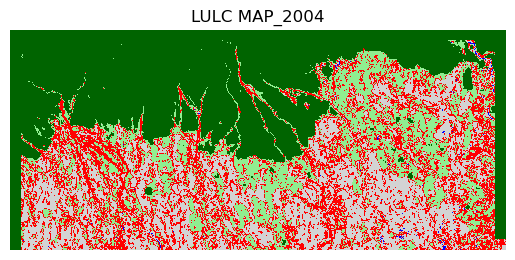

(1280, 2880)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2004.tif


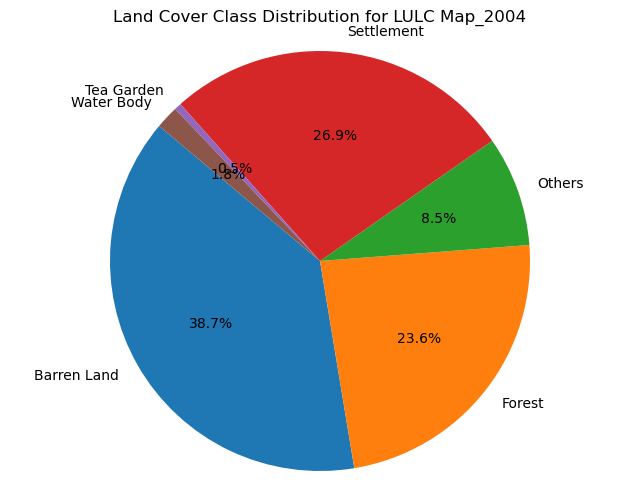

1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 125ms/step


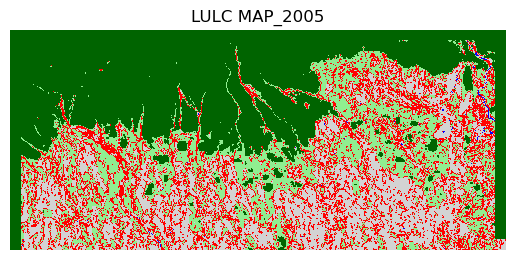

(1280, 2880)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2005.tif


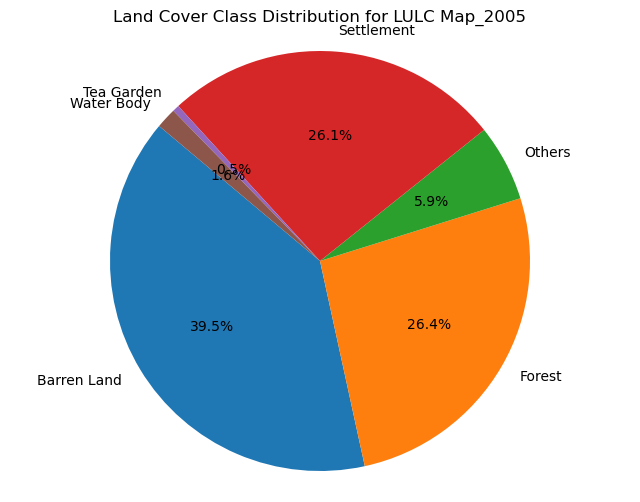

C:\Users\mrg22-020914479\.conda\envs\TestDL\Lib\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 375ms/step


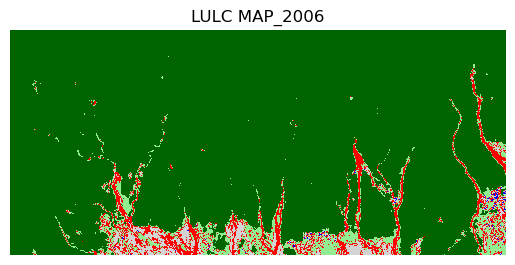

(640, 1408)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2006.tif


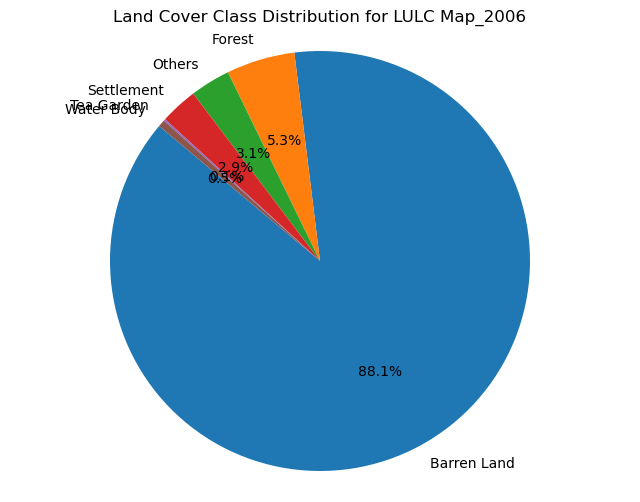

1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 233ms/step


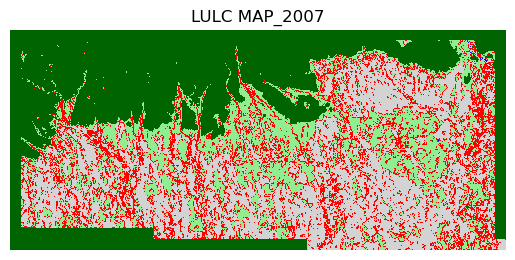

(1280, 2880)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2007.tif


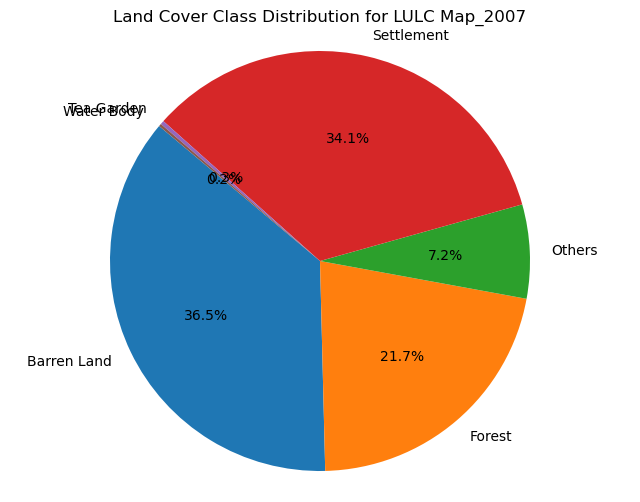

1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 495ms/step


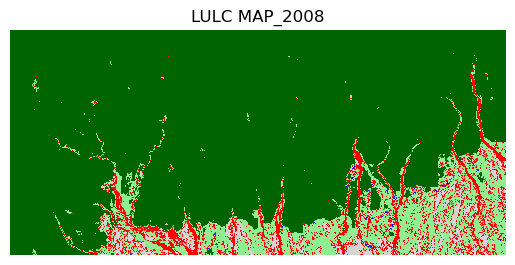

(640, 1408)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2008.tif


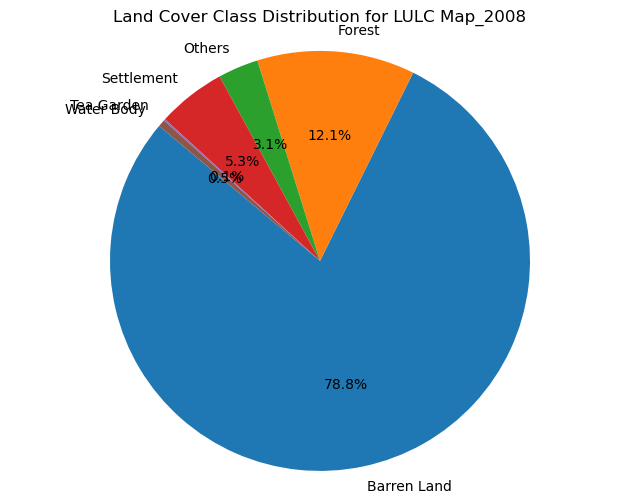

1/1 [==============================] - 1s 531ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 449ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 1s 503ms/step


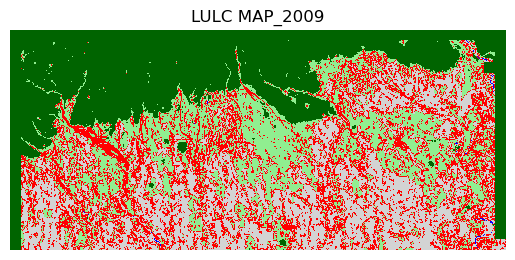

(1280, 2880)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2009.tif


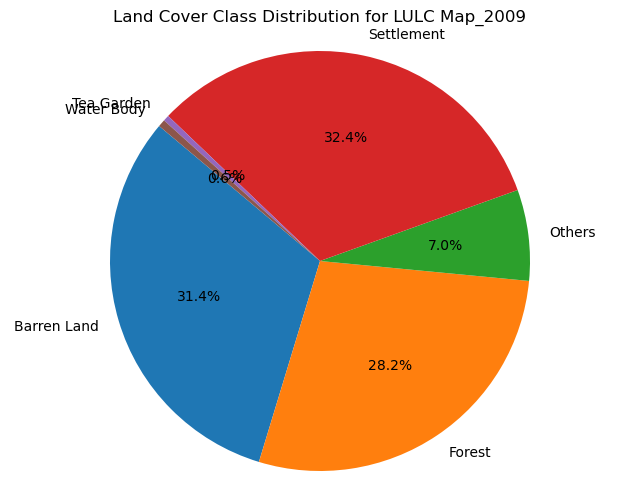

1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 156ms/step


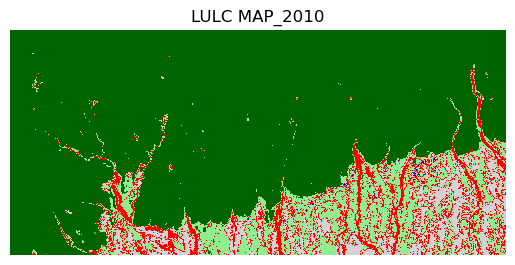

(640, 1408)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2010.tif


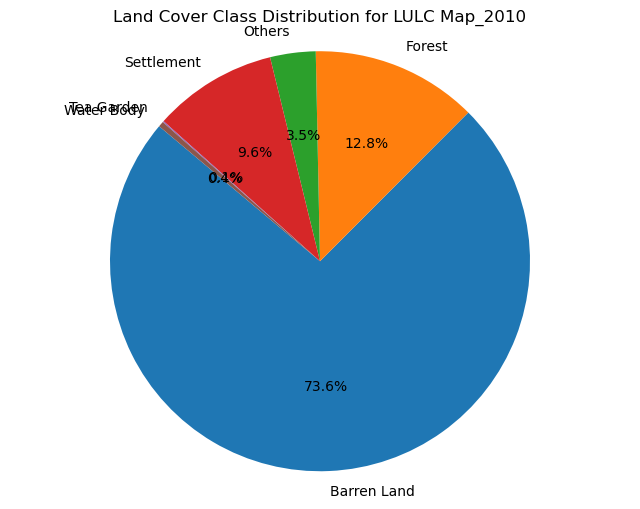

1/1 [==============================] - 0s 466ms/step


1/1 [==============================] - 0s 412ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 1s 581ms/step


1/1 [==============================] - 0s 469ms/step


1/1 [==============================] - 0s 401ms/step


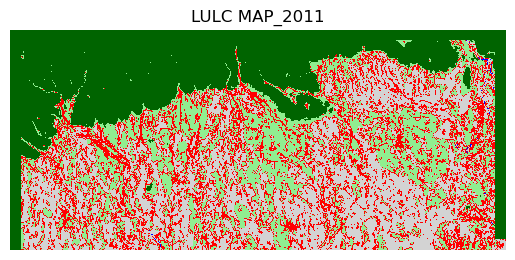

(1280, 2880)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2011.tif


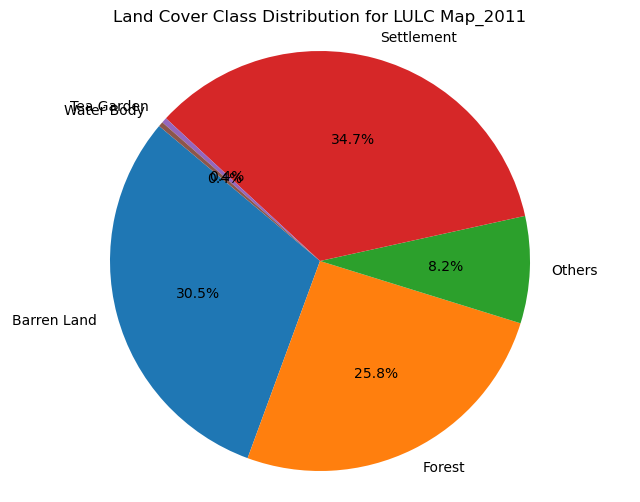

1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 234ms/step


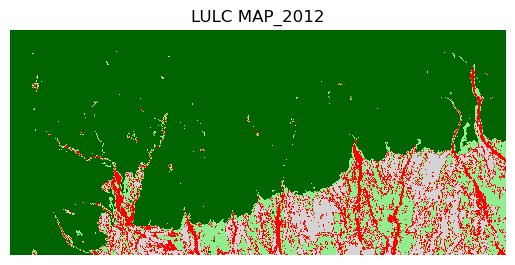

(640, 1408)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2012.tif


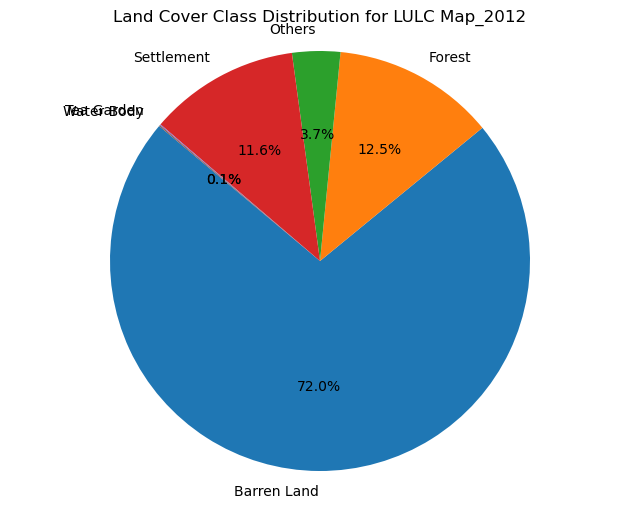

1/1 [==============================] - 1s 547ms/step


1/1 [==============================] - 0s 469ms/step


1/1 [==============================] - 0s 453ms/step


1/1 [==============================] - 1s 792ms/step


1/1 [==============================] - 1s 601ms/step


1/1 [==============================] - 1s 555ms/step


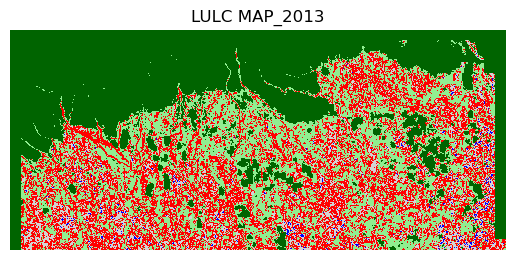

(1280, 2880)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2013.tif


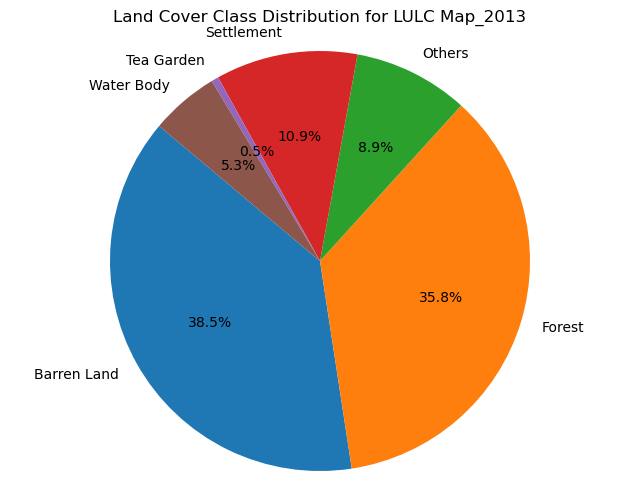

1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 391ms/step


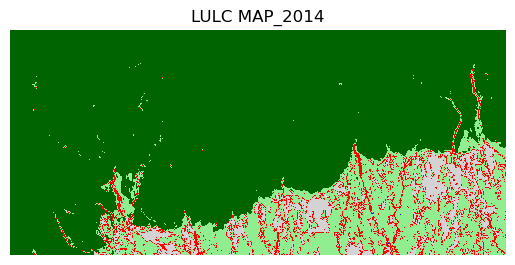

(640, 1408)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2014.tif


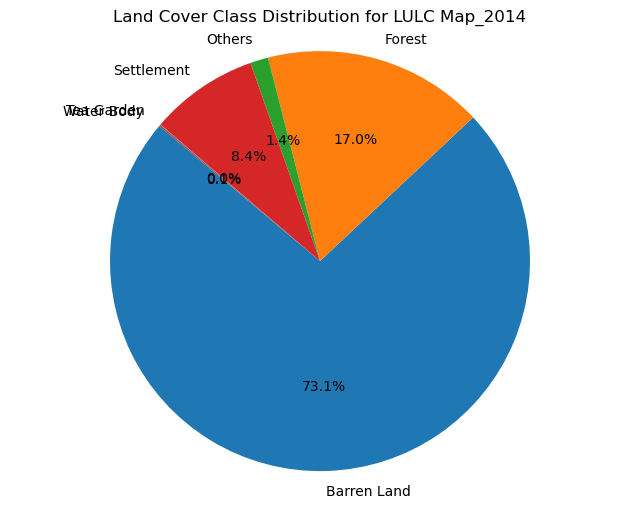

1/1 [==============================] - 1s 722ms/step


1/1 [==============================] - 1s 648ms/step


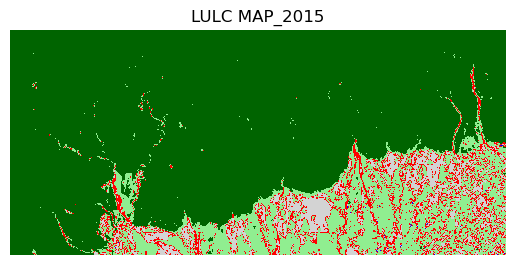

(640, 1408)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2015.tif


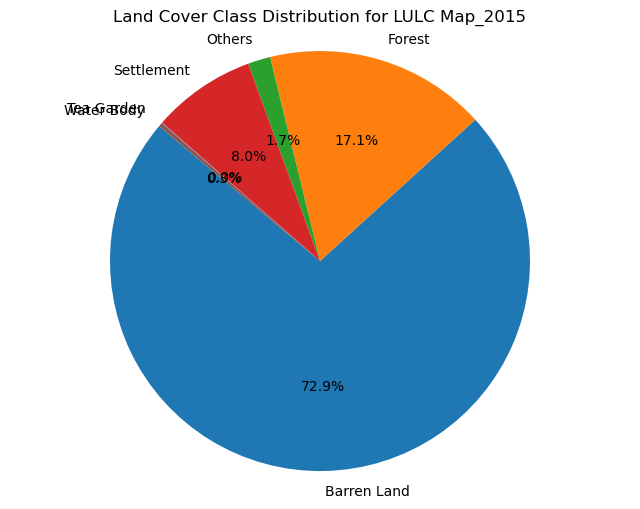

1/1 [==============================] - 1s 641ms/step


1/1 [==============================] - 1s 523ms/step


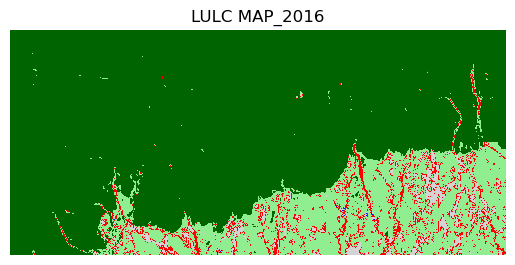

(640, 1408)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2016.tif


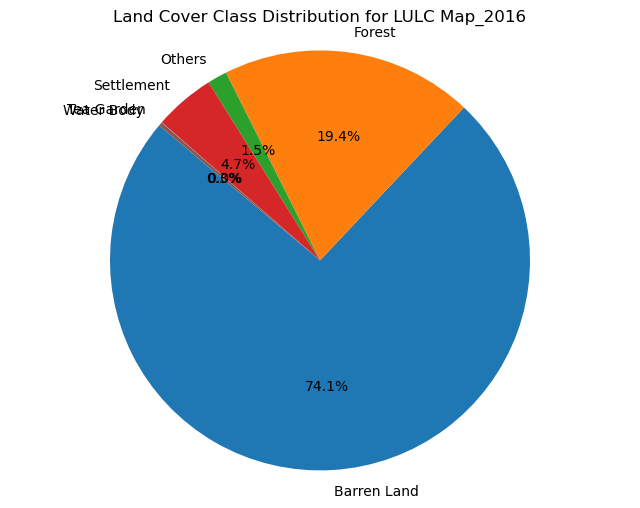

1/1 [==============================] - 0s 482ms/step


1/1 [==============================] - 1s 977ms/step


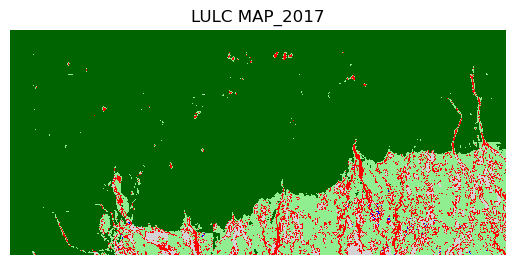

(640, 1408)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2017.tif


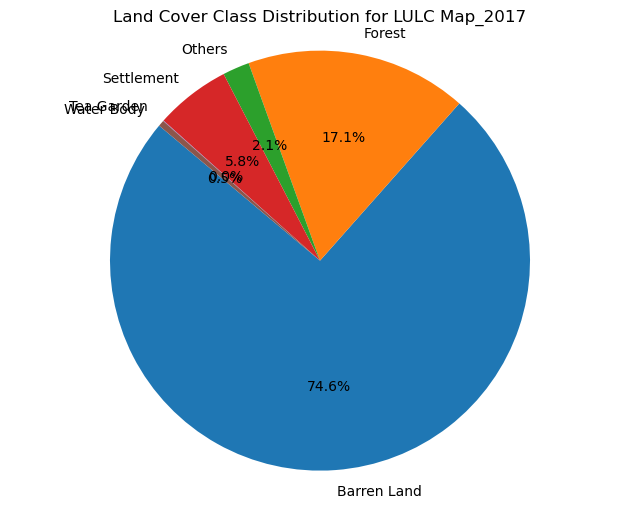

1/1 [==============================] - 1s 719ms/step


1/1 [==============================] - 1s 687ms/step


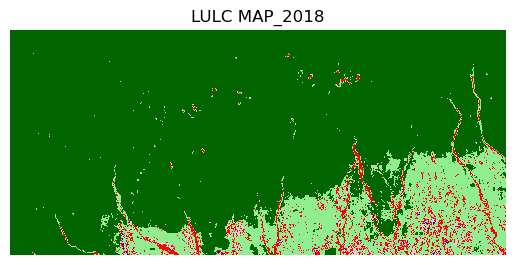

(640, 1408)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2018.tif


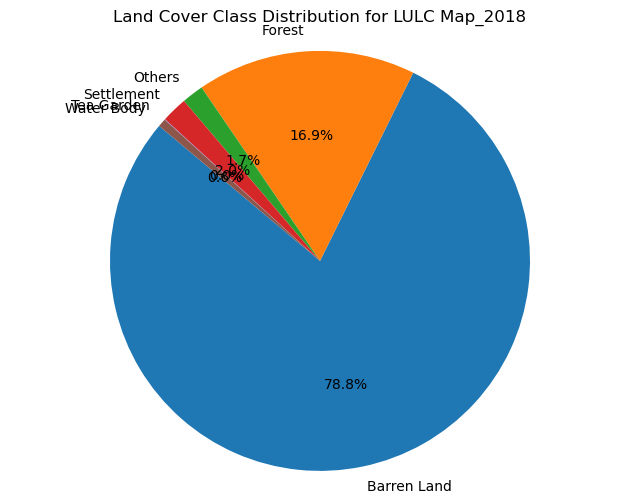

1/1 [==============================] - 1s 561ms/step


1/1 [==============================] - 1s 562ms/step


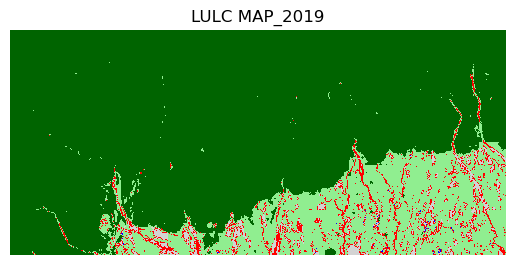

(640, 1408)
Saved output to D:/Jintu/Jintu_LULC/13Dec_2023/OutPut/2019.tif


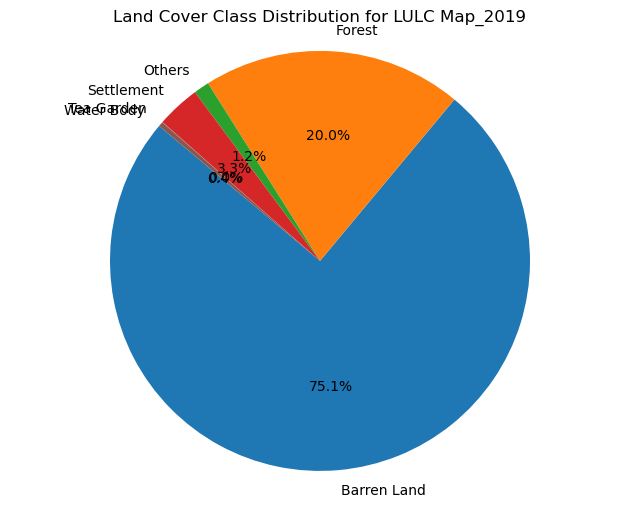

In [19]:
import os

# List of folder paths
folder_paths = [X5,X7,X6,X13,X1,X2,X3,X4,X9,X10,X8,X12,X11]

# Get a list of all files in each folder and sort them
sorted_files = []
max_num_images = 0  # Initialize a variable to keep track of the maximum number of images


for folder_path in folder_paths:
    files = os.listdir(folder_path)
    files.sort()
    sorted_files.append(files)
    
    # Update max_num_images if the current folder has more images
    max_num_images = max(max_num_images, len(files))
    

# Determine the total number of images based on the folder with the highest number of images
num_images = max_num_images

# print(num_images)

# Initialize a variable to keep track of the current image index
image_index = 0

# Continue processing images in a loop until all images are processed
while image_index < num_images:
    # Initialize an empty list to store the selected file paths for this pass
    selected_file_paths = []

    # Loop through each folder and select the image at the current index
    for folder_index, folder_path in enumerate(folder_paths):
        # If there's only one file in the folder, use that file repeatedly
        if len(sorted_files[folder_index]) == 1:
            file_index = 0
        else:
            # Get the file path at the current index (image_index) for the current folder
            file_index = min(image_index, len(sorted_files[folder_index]) - 1)
        file_path = os.path.join(folder_path, sorted_files[folder_index][file_index])
        selected_file_paths.append(file_path)
        
    
#     print(selected_file_paths)
    # Call the predict_and_reconstruct function using the list of selected images for the current pass
    reconstruct_image_from_files(selected_file_paths, model)

    # Increment the image index for the next iteration
    image_index += 1


In [24]:
import os

# Specify the directory path
directory = r"E:\Jintu\Lulc Classification\100 Epoch Results\Tiff File"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)


In [ ]:
model_path = 'C:/Users/mrg22-020914479/testndvi.hdf5'

In [ ]:
model = tf.keras.models.load_model(model_path)

In [ ]:
import os

# List of folder paths
folder_paths = [
    pred_ndvi_folder,
    pred_ndwi_folder
]

# Get a list of all files in each folder and sort them
sorted_files = []
max_num_images = 0  # Initialize a variable to keep track of the maximum number of images


for folder_path in folder_paths:
    files = os.listdir(folder_path)
    files.sort()
    sorted_files.append(files)
    
    # Update max_num_images if the current folder has more images
    max_num_images = max(max_num_images, len(files))
    

# Determine the total number of images based on the folder with the highest number of images
num_images = max_num_images

# print(num_images)

# Initialize a variable to keep track of the current image index
image_index = 0

# Continue processing images in a loop until all images are processed
while image_index < num_images:
    # Initialize an empty list to store the selected file paths for this pass
    selected_file_paths = []

    # Loop through each folder and select the image at the current index
    for folder_index, folder_path in enumerate(folder_paths):
        # If there's only one file in the folder, use that file repeatedly
        if len(sorted_files[folder_index]) == 1:
            file_index = 0
        else:
            # Get the file path at the current index (image_index) for the current folder
            file_index = min(image_index, len(sorted_files[folder_index]) - 1)
        file_path = os.path.join(folder_path, sorted_files[folder_index][file_index])
        selected_file_paths.append(file_path)
        
    
#     print(selected_file_paths)
    # Call the predict_and_reconstruct function using the list of selected images for the current pass
    reconstruct_image_from_files(selected_file_paths, model)

    # Increment the image index for the next iteration
    image_index += 1
